In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try5"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 2 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
input_quantization = 9
inner_quantization = 9
output_quantization = 9
integer_part = 1
default_quantization = 9
default_integer_part = 3

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.464568000830314


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
#, symmetric=1, keep_negative=1
input_quantizer = quantized_bits(bits=input_quantization, integer=integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
Q = "RND_CONV"
O = "SAT"
N = "0"
default_quantization_string = 'ap_fixed<' + str(default_quantization) + ',' + str(default_integer_part) + ',' + Q + ',' + O + ',' + N + '>'
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + ',' + Q + ',' + O + ',' + N + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(bits=input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 597us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
config['IOType'] = 'io_parallel'
config['Model']['Precision']['default'] = default_quantization_string
config['Model']['Strategy'] = 'Resource'
config['Model']['ReuseFactor'] = 64 # Valid ReuseFactor(s): 1,2,4,8,16,32,64
config['Model']['TraceOutput'] = True
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         ap_fixed<9,3,RND_CONV,SAT,0>
  ReuseFactor:       8
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       True
LayerName
  input_qdense_input
    Trace:           True
 

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

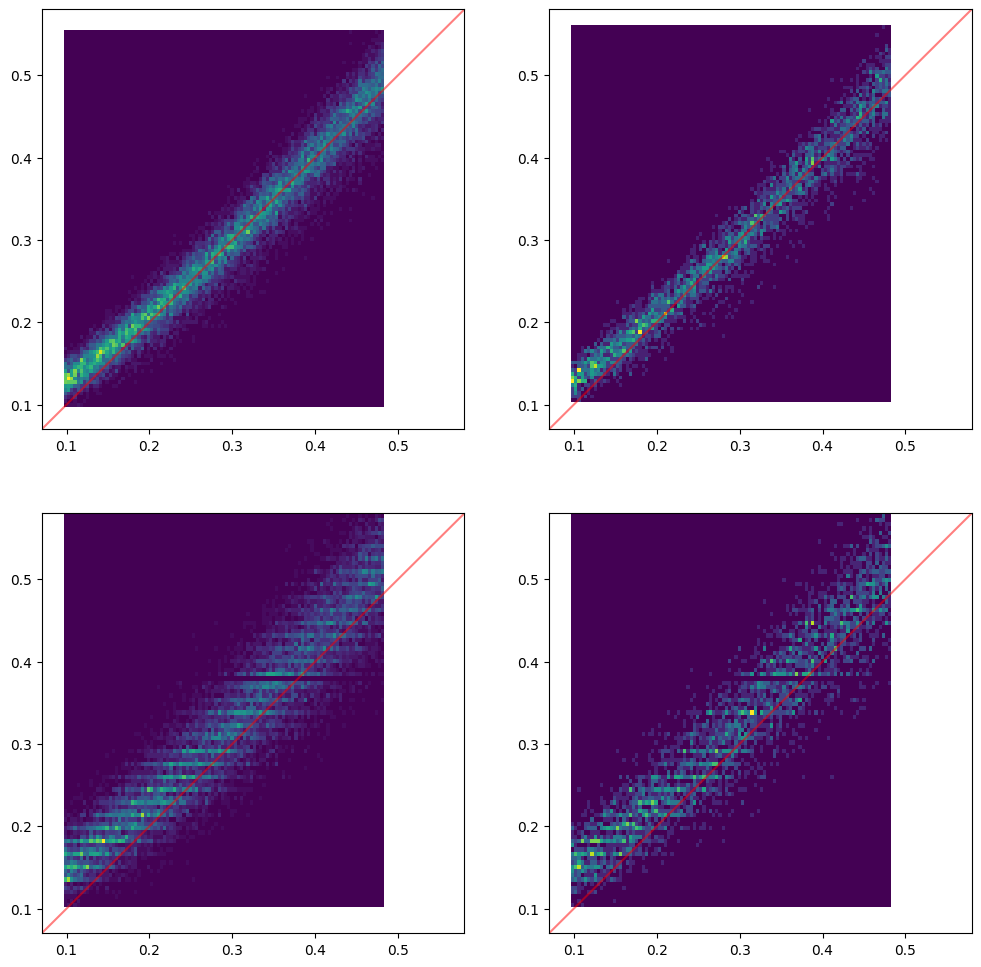

In [17]:
nbins = 100
a = 0.07; b = 0.58
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 17:34:31 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 200-777] Using interface defaults for 'Vivado' flow target.
INFO: [HLS 200-1995] There were 6,253 instructions in the design after the 'Compile/Link' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_resource_rf_leq_nin<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>*, ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_resource.h:59:17)
INFO: [HLS 214-131] Inlining function 'nnet::Dense

INFO: [HLS 214-186] Unrolling loop 'InitAccum' (firmware/nnet_utils/nnet_dense_resource.h:40:5) in function 'nnet::dense_resource_rf_leq_nin<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' completely with a factor of 64 (firmware/nnet_utils/nnet_dense_resource.h:15:0)
INFO: [HLS 214-186] Unrolling loop 'VITIS_LOOP_473_1' (firmware/nnet_utils/nnet_activation.h:473:20) in function 'nnet::hard_sigmoid<ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, hard_sigmoid_config4>' completely with a factor of 100 (firmware/nnet_utils/nnet_activation.h:470:0)
INFO: [HLS 214-186] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:80:5) in function 'nnet::dense_resource_rf_leq_nin<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 100 (firmware/nnet_utils/nnet_dense_resource.h:15:0)
INFO: [HLS 214-1

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:46) in function 'dense_resource_rf_leq_nin<ap_ufixed,ap_fixed<26,10,5,3,0>,config5>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:46) in function 'dense_resource_rf_leq_nin<ap_ufixed,ap_fixed<25,9,5,3,0>,config8>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:46) in function 'dense_resource_rf_leq_nin<ap_fixed,ap_fixed<26,13,5,3,0>,config2>'.
INFO: [HLS 200-111] Finished Architecture Synthesis: CPU user time: 151.8 seconds. CPU system time: 0.15 seconds. Elapsed time: 152.04 seconds; current allocated memory: 2.193 GB.
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_26_13_5_3_0_config

INFO: [HLS 200-111] Finished Scheduling: CPU user time: 75.36 seconds. CPU system time: 0.02 seconds. Elapsed time: 75.4 seconds; current allocated memory: 2.760 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 4.87 seconds. CPU system time: 0.04 seconds. Elapsed time: 4.91 seconds; current allocated memory: 2.760 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<26, 10, 5, 3, 0>, ap_ufixed<9,

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.38 seconds. CPU system time: 0 seconds. Elapsed time: 0.39 seconds; current allocated memory: 2.760 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_26_13_5_3_0_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_26_13_5_3_0_config2_s_w2_92_ROM_NP_BRAM_1R' to 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_26_13_5_3_0_config2_s_w2_92_ROM_Nbkb' due to the length limit 80
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_26_13_5_3_0_config2_s' pipeline 'ReuseLoop' pipeline type 'rewind pipeline'
INFO: [HLS 200-1552] Enabling free running pipeline (frp) architecture

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/input_qdense_input' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer10_out' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on function 'myproject' to 'ap_ctrl_hs'.
INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_1_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_2_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_3_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-2

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_29_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_30_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_31_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_32_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_33_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_34_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_35_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_36_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_37_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_38_U(myprojec

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_5_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_6_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_7_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_8_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_9_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_10_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_11_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_12_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_13_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_14_U(myproject_fif

Processing input 0
Predictions
0.448626 
Quantized predictions
0.417969 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-333] Generating C post check test bench ...
INFO: [COSIM 212-12] Generating RTL test bench ...
INFO: [COSIM 212-1] *** C/RTL co-simulation file generation completed. ***
INFO: [HLS 200-111] Finished Command cosim_design CPU user time: 88.38 seconds. CPU system time: 3.84 seconds. Elapsed time: 92.12 seconds; current allocated memory: 6.703 MB.
INFO: [COSIM 212-302] Starting C TB testing ...  
Processing input 0
Predictions
0.448626 
Quantized predictions
0.417969 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-323] Starting verilog simulation...
INFO: [COSIM 212-15] Starting XSIM ...
Vivado Simulator v2023.1
Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.
Running: /opt/Xilinx/Vivado/2023.1/bin/unwrapped/lnx64.o/xelab

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_16ns_31_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_16ns_31_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_fifo_w16_d2_S.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_fifo_w16_d2_S
INFO: [VRFC 10-311] analyzing module myproject_fifo_w16_d2_S_ShiftReg
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_5s_21_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_5s_21_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/wav

Starting static elaboration
Pass Through NonSizing Optimizer


Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling package xil_defaultlib.$unit_dataflow_monitor_sv
Compiling module xil_defaultlib.myproject_dense_resource_rf_leq_...
Compiling module xil_defaultlib.myproject_lshr_900ns_7ns_900_7_1...
Compiling module xil_defaultlib.myproject_lshr_900ns_8ns_900_7_1...
Compiling module xil_defaultlib.myproject_lshr_900ns_9ns_900_7_1...
Compiling module xil_defaultlib.myproject_lshr_900ns_10ns_900_7_...
Compiling module xil_defaultlib.myproject_mul_9s_9s_18_3_1(NUM_S...
Compiling module xil_defaultlib.myproject_mul_9s_6s_15_3_1(NUM_S...
Compiling module xil_defaultlib.myproject_flow_control_loop_pipe
Compiling module xil_defaultlib.myproject_frp_pipeline_valid(Pip...
Compiling module xil_defaultlib.myproject_frp_fifoout(BlockingTy...
Compiling module xil_defaultlib.myproject_dense_resource_rf_leq_...
Compiling module xil_defaultlib.myproject_frp_pipe

// RTL Simulation : 1 / 4000 [85.96%] @ "418000"
// RTL Simulation : 2 / 4000 [85.96%] @ "468000"
// RTL Simulation : 3 / 4000 [85.96%] @ "518000"
// RTL Simulation : 4 / 4000 [85.96%] @ "568000"
// RTL Simulation : 5 / 4000 [85.96%] @ "618000"
// RTL Simulation : 6 / 4000 [85.96%] @ "668000"
// RTL Simulation : 7 / 4000 [85.96%] @ "718000"
// RTL Simulation : 8 / 4000 [85.96%] @ "768000"
// RTL Simulation : 9 / 4000 [85.96%] @ "818000"
// RTL Simulation : 10 / 4000 [85.96%] @ "868000"
// RTL Simulation : 11 / 4000 [85.96%] @ "918000"
// RTL Simulation : 12 / 4000 [85.96%] @ "968000"
// RTL Simulation : 13 / 4000 [85.96%] @ "1018000"
// RTL Simulation : 14 / 4000 [85.96%] @ "1068000"
// RTL Simulation : 15 / 4000 [85.96%] @ "1118000"
// RTL Simulation : 16 / 4000 [85.96%] @ "1168000"
// RTL Simulation : 17 / 4000 [85.96%] @ "1218000"
// RTL Simulation : 18 / 4000 [85.96%] @ "1268000"
// RTL Simulation : 19 / 4000 [85.96%] @ "1318000"
// RTL Simulation : 20 / 4000 [85.96%] @ "1368000"
/

// RTL Simulation : 161 / 4000 [85.96%] @ "8418000"
// RTL Simulation : 162 / 4000 [85.96%] @ "8468000"
// RTL Simulation : 163 / 4000 [85.96%] @ "8518000"
// RTL Simulation : 164 / 4000 [85.96%] @ "8568000"
// RTL Simulation : 165 / 4000 [85.96%] @ "8618000"
// RTL Simulation : 166 / 4000 [85.96%] @ "8668000"
// RTL Simulation : 167 / 4000 [85.96%] @ "8718000"
// RTL Simulation : 168 / 4000 [85.96%] @ "8768000"
// RTL Simulation : 169 / 4000 [85.96%] @ "8818000"
// RTL Simulation : 170 / 4000 [85.96%] @ "8868000"
// RTL Simulation : 171 / 4000 [85.96%] @ "8918000"
// RTL Simulation : 172 / 4000 [85.96%] @ "8968000"
// RTL Simulation : 173 / 4000 [85.96%] @ "9018000"
// RTL Simulation : 174 / 4000 [85.96%] @ "9068000"
// RTL Simulation : 175 / 4000 [85.96%] @ "9118000"
// RTL Simulation : 176 / 4000 [85.96%] @ "9168000"
// RTL Simulation : 177 / 4000 [85.96%] @ "9218000"
// RTL Simulation : 178 / 4000 [85.96%] @ "9268000"
// RTL Simulation : 179 / 4000 [85.96%] @ "9318000"
// RTL Simul

// RTL Simulation : 317 / 4000 [85.96%] @ "16218000"
// RTL Simulation : 318 / 4000 [85.96%] @ "16268000"
// RTL Simulation : 319 / 4000 [85.96%] @ "16318000"
// RTL Simulation : 320 / 4000 [85.96%] @ "16368000"
// RTL Simulation : 321 / 4000 [85.96%] @ "16418000"
// RTL Simulation : 322 / 4000 [85.96%] @ "16468000"
// RTL Simulation : 323 / 4000 [85.96%] @ "16518000"
// RTL Simulation : 324 / 4000 [85.96%] @ "16568000"
// RTL Simulation : 325 / 4000 [85.96%] @ "16618000"
// RTL Simulation : 326 / 4000 [85.96%] @ "16668000"
// RTL Simulation : 327 / 4000 [85.96%] @ "16718000"
// RTL Simulation : 328 / 4000 [85.96%] @ "16768000"
// RTL Simulation : 329 / 4000 [85.96%] @ "16818000"
// RTL Simulation : 330 / 4000 [85.96%] @ "16868000"
// RTL Simulation : 331 / 4000 [85.96%] @ "16918000"
// RTL Simulation : 332 / 4000 [85.96%] @ "16968000"
// RTL Simulation : 333 / 4000 [85.96%] @ "17018000"
// RTL Simulation : 334 / 4000 [85.96%] @ "17068000"
// RTL Simulation : 335 / 4000 [85.96%] @ "171

// RTL Simulation : 473 / 4000 [85.96%] @ "24018000"
// RTL Simulation : 474 / 4000 [85.96%] @ "24068000"
// RTL Simulation : 475 / 4000 [85.96%] @ "24118000"
// RTL Simulation : 476 / 4000 [85.96%] @ "24168000"
// RTL Simulation : 477 / 4000 [85.96%] @ "24218000"
// RTL Simulation : 478 / 4000 [85.96%] @ "24268000"
// RTL Simulation : 479 / 4000 [85.96%] @ "24318000"
// RTL Simulation : 480 / 4000 [85.96%] @ "24368000"
// RTL Simulation : 481 / 4000 [85.96%] @ "24418000"
// RTL Simulation : 482 / 4000 [85.96%] @ "24468000"
// RTL Simulation : 483 / 4000 [85.96%] @ "24518000"
// RTL Simulation : 484 / 4000 [85.96%] @ "24568000"
// RTL Simulation : 485 / 4000 [85.96%] @ "24618000"
// RTL Simulation : 486 / 4000 [85.96%] @ "24668000"
// RTL Simulation : 487 / 4000 [85.96%] @ "24718000"
// RTL Simulation : 488 / 4000 [85.96%] @ "24768000"
// RTL Simulation : 489 / 4000 [85.96%] @ "24818000"
// RTL Simulation : 490 / 4000 [85.96%] @ "24868000"
// RTL Simulation : 491 / 4000 [85.96%] @ "249

// RTL Simulation : 629 / 4000 [85.96%] @ "31818000"
// RTL Simulation : 630 / 4000 [85.96%] @ "31868000"
// RTL Simulation : 631 / 4000 [85.96%] @ "31918000"
// RTL Simulation : 632 / 4000 [85.96%] @ "31968000"
// RTL Simulation : 633 / 4000 [85.96%] @ "32018000"
// RTL Simulation : 634 / 4000 [85.96%] @ "32068000"
// RTL Simulation : 635 / 4000 [85.96%] @ "32118000"
// RTL Simulation : 636 / 4000 [85.96%] @ "32168000"
// RTL Simulation : 637 / 4000 [85.96%] @ "32218000"
// RTL Simulation : 638 / 4000 [85.96%] @ "32268000"
// RTL Simulation : 639 / 4000 [85.96%] @ "32318000"
// RTL Simulation : 640 / 4000 [85.96%] @ "32368000"
// RTL Simulation : 641 / 4000 [85.96%] @ "32418000"
// RTL Simulation : 642 / 4000 [85.96%] @ "32468000"
// RTL Simulation : 643 / 4000 [85.96%] @ "32518000"
// RTL Simulation : 644 / 4000 [85.96%] @ "32568000"
// RTL Simulation : 645 / 4000 [85.96%] @ "32618000"
// RTL Simulation : 646 / 4000 [85.96%] @ "32668000"
// RTL Simulation : 647 / 4000 [85.96%] @ "327

// RTL Simulation : 785 / 4000 [85.96%] @ "39618000"
// RTL Simulation : 786 / 4000 [85.96%] @ "39668000"
// RTL Simulation : 787 / 4000 [85.96%] @ "39718000"
// RTL Simulation : 788 / 4000 [85.96%] @ "39768000"
// RTL Simulation : 789 / 4000 [85.96%] @ "39818000"
// RTL Simulation : 790 / 4000 [85.96%] @ "39868000"
// RTL Simulation : 791 / 4000 [85.96%] @ "39918000"
// RTL Simulation : 792 / 4000 [85.96%] @ "39968000"
// RTL Simulation : 793 / 4000 [85.96%] @ "40018000"
// RTL Simulation : 794 / 4000 [85.96%] @ "40068000"
// RTL Simulation : 795 / 4000 [85.96%] @ "40118000"
// RTL Simulation : 796 / 4000 [85.96%] @ "40168000"
// RTL Simulation : 797 / 4000 [85.96%] @ "40218000"
// RTL Simulation : 798 / 4000 [85.96%] @ "40268000"
// RTL Simulation : 799 / 4000 [85.96%] @ "40318000"
// RTL Simulation : 800 / 4000 [85.96%] @ "40368000"
// RTL Simulation : 801 / 4000 [85.96%] @ "40418000"
// RTL Simulation : 802 / 4000 [85.96%] @ "40468000"
// RTL Simulation : 803 / 4000 [85.96%] @ "405

// RTL Simulation : 941 / 4000 [85.96%] @ "47418000"
// RTL Simulation : 942 / 4000 [85.96%] @ "47468000"
// RTL Simulation : 943 / 4000 [85.96%] @ "47518000"
// RTL Simulation : 944 / 4000 [85.96%] @ "47568000"
// RTL Simulation : 945 / 4000 [85.96%] @ "47618000"
// RTL Simulation : 946 / 4000 [85.96%] @ "47668000"
// RTL Simulation : 947 / 4000 [85.96%] @ "47718000"
// RTL Simulation : 948 / 4000 [85.96%] @ "47768000"
// RTL Simulation : 949 / 4000 [85.96%] @ "47818000"
// RTL Simulation : 950 / 4000 [85.96%] @ "47868000"
// RTL Simulation : 951 / 4000 [85.96%] @ "47918000"
// RTL Simulation : 952 / 4000 [85.96%] @ "47968000"
// RTL Simulation : 953 / 4000 [85.96%] @ "48018000"
// RTL Simulation : 954 / 4000 [85.96%] @ "48068000"
// RTL Simulation : 955 / 4000 [85.96%] @ "48118000"
// RTL Simulation : 956 / 4000 [85.96%] @ "48168000"
// RTL Simulation : 957 / 4000 [85.96%] @ "48218000"
// RTL Simulation : 958 / 4000 [85.96%] @ "48268000"
// RTL Simulation : 959 / 4000 [85.96%] @ "483

// RTL Simulation : 1095 / 4000 [85.96%] @ "55118000"
// RTL Simulation : 1096 / 4000 [85.96%] @ "55168000"
// RTL Simulation : 1097 / 4000 [85.96%] @ "55218000"
// RTL Simulation : 1098 / 4000 [85.96%] @ "55268000"
// RTL Simulation : 1099 / 4000 [85.96%] @ "55318000"
// RTL Simulation : 1100 / 4000 [85.96%] @ "55368000"
// RTL Simulation : 1101 / 4000 [85.96%] @ "55418000"
// RTL Simulation : 1102 / 4000 [85.96%] @ "55468000"
// RTL Simulation : 1103 / 4000 [85.96%] @ "55518000"
// RTL Simulation : 1104 / 4000 [85.96%] @ "55568000"
// RTL Simulation : 1105 / 4000 [85.96%] @ "55618000"
// RTL Simulation : 1106 / 4000 [85.96%] @ "55668000"
// RTL Simulation : 1107 / 4000 [85.96%] @ "55718000"
// RTL Simulation : 1108 / 4000 [85.96%] @ "55768000"
// RTL Simulation : 1109 / 4000 [85.96%] @ "55818000"
// RTL Simulation : 1110 / 4000 [85.96%] @ "55868000"
// RTL Simulation : 1111 / 4000 [85.96%] @ "55918000"
// RTL Simulation : 1112 / 4000 [85.96%] @ "55968000"
// RTL Simulation : 1113 / 4

// RTL Simulation : 1247 / 4000 [85.96%] @ "62718000"
// RTL Simulation : 1248 / 4000 [85.96%] @ "62768000"
// RTL Simulation : 1249 / 4000 [85.96%] @ "62818000"
// RTL Simulation : 1250 / 4000 [85.96%] @ "62868000"
// RTL Simulation : 1251 / 4000 [85.96%] @ "62918000"
// RTL Simulation : 1252 / 4000 [85.96%] @ "62968000"
// RTL Simulation : 1253 / 4000 [85.96%] @ "63018000"
// RTL Simulation : 1254 / 4000 [85.96%] @ "63068000"
// RTL Simulation : 1255 / 4000 [85.96%] @ "63118000"
// RTL Simulation : 1256 / 4000 [85.96%] @ "63168000"
// RTL Simulation : 1257 / 4000 [85.96%] @ "63218000"
// RTL Simulation : 1258 / 4000 [85.96%] @ "63268000"
// RTL Simulation : 1259 / 4000 [85.96%] @ "63318000"
// RTL Simulation : 1260 / 4000 [85.96%] @ "63368000"
// RTL Simulation : 1261 / 4000 [85.96%] @ "63418000"
// RTL Simulation : 1262 / 4000 [85.96%] @ "63468000"
// RTL Simulation : 1263 / 4000 [85.96%] @ "63518000"
// RTL Simulation : 1264 / 4000 [85.96%] @ "63568000"
// RTL Simulation : 1265 / 4

// RTL Simulation : 1399 / 4000 [85.96%] @ "70318000"
// RTL Simulation : 1400 / 4000 [85.96%] @ "70368000"
// RTL Simulation : 1401 / 4000 [85.96%] @ "70418000"
// RTL Simulation : 1402 / 4000 [85.96%] @ "70468000"
// RTL Simulation : 1403 / 4000 [85.96%] @ "70518000"
// RTL Simulation : 1404 / 4000 [85.96%] @ "70568000"
// RTL Simulation : 1405 / 4000 [85.96%] @ "70618000"
// RTL Simulation : 1406 / 4000 [85.96%] @ "70668000"
// RTL Simulation : 1407 / 4000 [85.96%] @ "70718000"
// RTL Simulation : 1408 / 4000 [85.96%] @ "70768000"
// RTL Simulation : 1409 / 4000 [85.96%] @ "70818000"
// RTL Simulation : 1410 / 4000 [85.96%] @ "70868000"
// RTL Simulation : 1411 / 4000 [85.96%] @ "70918000"
// RTL Simulation : 1412 / 4000 [85.96%] @ "70968000"
// RTL Simulation : 1413 / 4000 [85.96%] @ "71018000"
// RTL Simulation : 1414 / 4000 [85.96%] @ "71068000"
// RTL Simulation : 1415 / 4000 [85.96%] @ "71118000"
// RTL Simulation : 1416 / 4000 [85.96%] @ "71168000"
// RTL Simulation : 1417 / 4

// RTL Simulation : 1551 / 4000 [85.96%] @ "77918000"
// RTL Simulation : 1552 / 4000 [85.96%] @ "77968000"
// RTL Simulation : 1553 / 4000 [85.96%] @ "78018000"
// RTL Simulation : 1554 / 4000 [85.96%] @ "78068000"
// RTL Simulation : 1555 / 4000 [85.96%] @ "78118000"
// RTL Simulation : 1556 / 4000 [85.96%] @ "78168000"
// RTL Simulation : 1557 / 4000 [85.96%] @ "78218000"
// RTL Simulation : 1558 / 4000 [85.96%] @ "78268000"
// RTL Simulation : 1559 / 4000 [85.96%] @ "78318000"
// RTL Simulation : 1560 / 4000 [85.96%] @ "78368000"
// RTL Simulation : 1561 / 4000 [85.96%] @ "78418000"
// RTL Simulation : 1562 / 4000 [85.96%] @ "78468000"
// RTL Simulation : 1563 / 4000 [85.96%] @ "78518000"
// RTL Simulation : 1564 / 4000 [85.96%] @ "78568000"
// RTL Simulation : 1565 / 4000 [85.96%] @ "78618000"
// RTL Simulation : 1566 / 4000 [85.96%] @ "78668000"
// RTL Simulation : 1567 / 4000 [85.96%] @ "78718000"
// RTL Simulation : 1568 / 4000 [85.96%] @ "78768000"
// RTL Simulation : 1569 / 4

// RTL Simulation : 1703 / 4000 [85.96%] @ "85518000"
// RTL Simulation : 1704 / 4000 [85.96%] @ "85568000"
// RTL Simulation : 1705 / 4000 [85.96%] @ "85618000"
// RTL Simulation : 1706 / 4000 [85.96%] @ "85668000"
// RTL Simulation : 1707 / 4000 [85.96%] @ "85718000"
// RTL Simulation : 1708 / 4000 [85.96%] @ "85768000"
// RTL Simulation : 1709 / 4000 [85.96%] @ "85818000"
// RTL Simulation : 1710 / 4000 [85.96%] @ "85868000"
// RTL Simulation : 1711 / 4000 [85.96%] @ "85918000"
// RTL Simulation : 1712 / 4000 [85.96%] @ "85968000"
// RTL Simulation : 1713 / 4000 [85.96%] @ "86018000"
// RTL Simulation : 1714 / 4000 [85.96%] @ "86068000"
// RTL Simulation : 1715 / 4000 [85.96%] @ "86118000"
// RTL Simulation : 1716 / 4000 [85.96%] @ "86168000"
// RTL Simulation : 1717 / 4000 [85.96%] @ "86218000"
// RTL Simulation : 1718 / 4000 [85.96%] @ "86268000"
// RTL Simulation : 1719 / 4000 [85.96%] @ "86318000"
// RTL Simulation : 1720 / 4000 [85.96%] @ "86368000"
// RTL Simulation : 1721 / 4

// RTL Simulation : 1856 / 4000 [85.96%] @ "93168000"
// RTL Simulation : 1857 / 4000 [85.96%] @ "93218000"
// RTL Simulation : 1858 / 4000 [85.96%] @ "93268000"
// RTL Simulation : 1859 / 4000 [85.96%] @ "93318000"
// RTL Simulation : 1860 / 4000 [85.96%] @ "93368000"
// RTL Simulation : 1861 / 4000 [85.96%] @ "93418000"
// RTL Simulation : 1862 / 4000 [85.96%] @ "93468000"
// RTL Simulation : 1863 / 4000 [85.96%] @ "93518000"
// RTL Simulation : 1864 / 4000 [85.96%] @ "93568000"
// RTL Simulation : 1865 / 4000 [85.96%] @ "93618000"
// RTL Simulation : 1866 / 4000 [85.96%] @ "93668000"
// RTL Simulation : 1867 / 4000 [85.96%] @ "93718000"
// RTL Simulation : 1868 / 4000 [85.96%] @ "93768000"
// RTL Simulation : 1869 / 4000 [85.96%] @ "93818000"
// RTL Simulation : 1870 / 4000 [85.96%] @ "93868000"
// RTL Simulation : 1871 / 4000 [85.96%] @ "93918000"
// RTL Simulation : 1872 / 4000 [85.96%] @ "93968000"
// RTL Simulation : 1873 / 4000 [85.96%] @ "94018000"
// RTL Simulation : 1874 / 4

// RTL Simulation : 2008 / 4000 [85.96%] @ "100768000"
// RTL Simulation : 2009 / 4000 [85.96%] @ "100818000"
// RTL Simulation : 2010 / 4000 [85.96%] @ "100868000"
// RTL Simulation : 2011 / 4000 [85.96%] @ "100918000"
// RTL Simulation : 2012 / 4000 [85.96%] @ "100968000"
// RTL Simulation : 2013 / 4000 [85.96%] @ "101018000"
// RTL Simulation : 2014 / 4000 [85.96%] @ "101068000"
// RTL Simulation : 2015 / 4000 [85.96%] @ "101118000"
// RTL Simulation : 2016 / 4000 [85.96%] @ "101168000"
// RTL Simulation : 2017 / 4000 [85.96%] @ "101218000"
// RTL Simulation : 2018 / 4000 [85.96%] @ "101268000"
// RTL Simulation : 2019 / 4000 [85.96%] @ "101318000"
// RTL Simulation : 2020 / 4000 [85.96%] @ "101368000"
// RTL Simulation : 2021 / 4000 [85.96%] @ "101418000"
// RTL Simulation : 2022 / 4000 [85.96%] @ "101468000"
// RTL Simulation : 2023 / 4000 [85.96%] @ "101518000"
// RTL Simulation : 2024 / 4000 [85.96%] @ "101568000"
// RTL Simulation : 2025 / 4000 [85.96%] @ "101618000"
// RTL Sim

// RTL Simulation : 2158 / 4000 [85.96%] @ "108268000"
// RTL Simulation : 2159 / 4000 [85.96%] @ "108318000"
// RTL Simulation : 2160 / 4000 [85.96%] @ "108368000"
// RTL Simulation : 2161 / 4000 [85.96%] @ "108418000"
// RTL Simulation : 2162 / 4000 [85.96%] @ "108468000"
// RTL Simulation : 2163 / 4000 [85.96%] @ "108518000"
// RTL Simulation : 2164 / 4000 [85.96%] @ "108568000"
// RTL Simulation : 2165 / 4000 [85.96%] @ "108618000"
// RTL Simulation : 2166 / 4000 [85.96%] @ "108668000"
// RTL Simulation : 2167 / 4000 [85.96%] @ "108718000"
// RTL Simulation : 2168 / 4000 [85.96%] @ "108768000"
// RTL Simulation : 2169 / 4000 [85.96%] @ "108818000"
// RTL Simulation : 2170 / 4000 [85.96%] @ "108868000"
// RTL Simulation : 2171 / 4000 [85.96%] @ "108918000"
// RTL Simulation : 2172 / 4000 [85.96%] @ "108968000"
// RTL Simulation : 2173 / 4000 [85.96%] @ "109018000"
// RTL Simulation : 2174 / 4000 [85.96%] @ "109068000"
// RTL Simulation : 2175 / 4000 [85.96%] @ "109118000"
// RTL Sim

// RTL Simulation : 2308 / 4000 [85.96%] @ "115768000"
// RTL Simulation : 2309 / 4000 [85.96%] @ "115818000"
// RTL Simulation : 2310 / 4000 [85.96%] @ "115868000"
// RTL Simulation : 2311 / 4000 [85.96%] @ "115918000"
// RTL Simulation : 2312 / 4000 [85.96%] @ "115968000"
// RTL Simulation : 2313 / 4000 [85.96%] @ "116018000"
// RTL Simulation : 2314 / 4000 [85.96%] @ "116068000"
// RTL Simulation : 2315 / 4000 [85.96%] @ "116118000"
// RTL Simulation : 2316 / 4000 [85.96%] @ "116168000"
// RTL Simulation : 2317 / 4000 [85.96%] @ "116218000"
// RTL Simulation : 2318 / 4000 [85.96%] @ "116268000"
// RTL Simulation : 2319 / 4000 [85.96%] @ "116318000"
// RTL Simulation : 2320 / 4000 [85.96%] @ "116368000"
// RTL Simulation : 2321 / 4000 [85.96%] @ "116418000"
// RTL Simulation : 2322 / 4000 [85.96%] @ "116468000"
// RTL Simulation : 2323 / 4000 [85.96%] @ "116518000"
// RTL Simulation : 2324 / 4000 [85.96%] @ "116568000"
// RTL Simulation : 2325 / 4000 [85.96%] @ "116618000"
// RTL Sim

// RTL Simulation : 2457 / 4000 [85.96%] @ "123218000"
// RTL Simulation : 2458 / 4000 [85.96%] @ "123268000"
// RTL Simulation : 2459 / 4000 [85.96%] @ "123318000"
// RTL Simulation : 2460 / 4000 [85.96%] @ "123368000"
// RTL Simulation : 2461 / 4000 [85.96%] @ "123418000"
// RTL Simulation : 2462 / 4000 [85.96%] @ "123468000"
// RTL Simulation : 2463 / 4000 [85.96%] @ "123518000"
// RTL Simulation : 2464 / 4000 [85.96%] @ "123568000"
// RTL Simulation : 2465 / 4000 [85.96%] @ "123618000"
// RTL Simulation : 2466 / 4000 [85.96%] @ "123668000"
// RTL Simulation : 2467 / 4000 [85.96%] @ "123718000"
// RTL Simulation : 2468 / 4000 [85.96%] @ "123768000"
// RTL Simulation : 2469 / 4000 [85.96%] @ "123818000"
// RTL Simulation : 2470 / 4000 [85.96%] @ "123868000"
// RTL Simulation : 2471 / 4000 [85.96%] @ "123918000"
// RTL Simulation : 2472 / 4000 [85.96%] @ "123968000"
// RTL Simulation : 2473 / 4000 [85.96%] @ "124018000"
// RTL Simulation : 2474 / 4000 [85.96%] @ "124068000"
// RTL Sim

// RTL Simulation : 2607 / 4000 [85.96%] @ "130718000"
// RTL Simulation : 2608 / 4000 [85.96%] @ "130768000"
// RTL Simulation : 2609 / 4000 [85.96%] @ "130818000"
// RTL Simulation : 2610 / 4000 [85.96%] @ "130868000"
// RTL Simulation : 2611 / 4000 [85.96%] @ "130918000"
// RTL Simulation : 2612 / 4000 [85.96%] @ "130968000"
// RTL Simulation : 2613 / 4000 [85.96%] @ "131018000"
// RTL Simulation : 2614 / 4000 [85.96%] @ "131068000"
// RTL Simulation : 2615 / 4000 [85.96%] @ "131118000"
// RTL Simulation : 2616 / 4000 [85.96%] @ "131168000"
// RTL Simulation : 2617 / 4000 [85.96%] @ "131218000"
// RTL Simulation : 2618 / 4000 [85.96%] @ "131268000"
// RTL Simulation : 2619 / 4000 [85.96%] @ "131318000"
// RTL Simulation : 2620 / 4000 [85.96%] @ "131368000"
// RTL Simulation : 2621 / 4000 [85.96%] @ "131418000"
// RTL Simulation : 2622 / 4000 [85.96%] @ "131468000"
// RTL Simulation : 2623 / 4000 [85.96%] @ "131518000"
// RTL Simulation : 2624 / 4000 [85.96%] @ "131568000"
// RTL Sim

// RTL Simulation : 2757 / 4000 [85.96%] @ "138218000"
// RTL Simulation : 2758 / 4000 [85.96%] @ "138268000"
// RTL Simulation : 2759 / 4000 [85.96%] @ "138318000"
// RTL Simulation : 2760 / 4000 [85.96%] @ "138368000"
// RTL Simulation : 2761 / 4000 [85.96%] @ "138418000"
// RTL Simulation : 2762 / 4000 [85.96%] @ "138468000"
// RTL Simulation : 2763 / 4000 [85.96%] @ "138518000"
// RTL Simulation : 2764 / 4000 [85.96%] @ "138568000"
// RTL Simulation : 2765 / 4000 [85.96%] @ "138618000"
// RTL Simulation : 2766 / 4000 [85.96%] @ "138668000"
// RTL Simulation : 2767 / 4000 [85.96%] @ "138718000"
// RTL Simulation : 2768 / 4000 [85.96%] @ "138768000"
// RTL Simulation : 2769 / 4000 [85.96%] @ "138818000"
// RTL Simulation : 2770 / 4000 [85.96%] @ "138868000"
// RTL Simulation : 2771 / 4000 [85.96%] @ "138918000"
// RTL Simulation : 2772 / 4000 [85.96%] @ "138968000"
// RTL Simulation : 2773 / 4000 [85.96%] @ "139018000"
// RTL Simulation : 2774 / 4000 [85.96%] @ "139068000"
// RTL Sim

// RTL Simulation : 2907 / 4000 [85.96%] @ "145718000"
// RTL Simulation : 2908 / 4000 [85.96%] @ "145768000"
// RTL Simulation : 2909 / 4000 [85.96%] @ "145818000"
// RTL Simulation : 2910 / 4000 [85.96%] @ "145868000"
// RTL Simulation : 2911 / 4000 [85.96%] @ "145918000"
// RTL Simulation : 2912 / 4000 [85.96%] @ "145968000"
// RTL Simulation : 2913 / 4000 [85.96%] @ "146018000"
// RTL Simulation : 2914 / 4000 [85.96%] @ "146068000"
// RTL Simulation : 2915 / 4000 [85.96%] @ "146118000"
// RTL Simulation : 2916 / 4000 [85.96%] @ "146168000"
// RTL Simulation : 2917 / 4000 [85.96%] @ "146218000"
// RTL Simulation : 2918 / 4000 [85.96%] @ "146268000"
// RTL Simulation : 2919 / 4000 [85.96%] @ "146318000"
// RTL Simulation : 2920 / 4000 [85.96%] @ "146368000"
// RTL Simulation : 2921 / 4000 [85.96%] @ "146418000"
// RTL Simulation : 2922 / 4000 [85.96%] @ "146468000"
// RTL Simulation : 2923 / 4000 [85.96%] @ "146518000"
// RTL Simulation : 2924 / 4000 [85.96%] @ "146568000"
// RTL Sim

// RTL Simulation : 3057 / 4000 [85.96%] @ "153218000"
// RTL Simulation : 3058 / 4000 [85.96%] @ "153268000"
// RTL Simulation : 3059 / 4000 [85.96%] @ "153318000"
// RTL Simulation : 3060 / 4000 [85.96%] @ "153368000"
// RTL Simulation : 3061 / 4000 [85.96%] @ "153418000"
// RTL Simulation : 3062 / 4000 [85.96%] @ "153468000"
// RTL Simulation : 3063 / 4000 [85.96%] @ "153518000"
// RTL Simulation : 3064 / 4000 [85.96%] @ "153568000"
// RTL Simulation : 3065 / 4000 [85.96%] @ "153618000"
// RTL Simulation : 3066 / 4000 [85.96%] @ "153668000"
// RTL Simulation : 3067 / 4000 [85.96%] @ "153718000"
// RTL Simulation : 3068 / 4000 [85.96%] @ "153768000"
// RTL Simulation : 3069 / 4000 [85.96%] @ "153818000"
// RTL Simulation : 3070 / 4000 [85.96%] @ "153868000"
// RTL Simulation : 3071 / 4000 [85.96%] @ "153918000"
// RTL Simulation : 3072 / 4000 [85.96%] @ "153968000"
// RTL Simulation : 3073 / 4000 [85.96%] @ "154018000"
// RTL Simulation : 3074 / 4000 [85.96%] @ "154068000"
// RTL Sim

// RTL Simulation : 3206 / 4000 [85.96%] @ "160668000"
// RTL Simulation : 3207 / 4000 [85.96%] @ "160718000"
// RTL Simulation : 3208 / 4000 [85.96%] @ "160768000"
// RTL Simulation : 3209 / 4000 [85.96%] @ "160818000"
// RTL Simulation : 3210 / 4000 [85.96%] @ "160868000"
// RTL Simulation : 3211 / 4000 [85.96%] @ "160918000"
// RTL Simulation : 3212 / 4000 [85.96%] @ "160968000"
// RTL Simulation : 3213 / 4000 [85.96%] @ "161018000"
// RTL Simulation : 3214 / 4000 [85.96%] @ "161068000"
// RTL Simulation : 3215 / 4000 [85.96%] @ "161118000"
// RTL Simulation : 3216 / 4000 [85.96%] @ "161168000"
// RTL Simulation : 3217 / 4000 [85.96%] @ "161218000"
// RTL Simulation : 3218 / 4000 [85.96%] @ "161268000"
// RTL Simulation : 3219 / 4000 [85.96%] @ "161318000"
// RTL Simulation : 3220 / 4000 [85.96%] @ "161368000"
// RTL Simulation : 3221 / 4000 [85.96%] @ "161418000"
// RTL Simulation : 3222 / 4000 [85.96%] @ "161468000"
// RTL Simulation : 3223 / 4000 [85.96%] @ "161518000"
// RTL Sim

// RTL Simulation : 3356 / 4000 [85.96%] @ "168168000"
// RTL Simulation : 3357 / 4000 [85.96%] @ "168218000"
// RTL Simulation : 3358 / 4000 [85.96%] @ "168268000"
// RTL Simulation : 3359 / 4000 [85.96%] @ "168318000"
// RTL Simulation : 3360 / 4000 [85.96%] @ "168368000"
// RTL Simulation : 3361 / 4000 [85.96%] @ "168418000"
// RTL Simulation : 3362 / 4000 [85.96%] @ "168468000"
// RTL Simulation : 3363 / 4000 [85.96%] @ "168518000"
// RTL Simulation : 3364 / 4000 [85.96%] @ "168568000"
// RTL Simulation : 3365 / 4000 [85.96%] @ "168618000"
// RTL Simulation : 3366 / 4000 [85.96%] @ "168668000"
// RTL Simulation : 3367 / 4000 [85.96%] @ "168718000"
// RTL Simulation : 3368 / 4000 [85.96%] @ "168768000"
// RTL Simulation : 3369 / 4000 [85.96%] @ "168818000"
// RTL Simulation : 3370 / 4000 [85.96%] @ "168868000"
// RTL Simulation : 3371 / 4000 [85.96%] @ "168918000"
// RTL Simulation : 3372 / 4000 [85.96%] @ "168968000"
// RTL Simulation : 3373 / 4000 [85.96%] @ "169018000"
// RTL Sim

// RTL Simulation : 3506 / 4000 [85.96%] @ "175668000"
// RTL Simulation : 3507 / 4000 [85.96%] @ "175718000"
// RTL Simulation : 3508 / 4000 [85.96%] @ "175768000"
// RTL Simulation : 3509 / 4000 [85.96%] @ "175818000"
// RTL Simulation : 3510 / 4000 [85.96%] @ "175868000"
// RTL Simulation : 3511 / 4000 [85.96%] @ "175918000"
// RTL Simulation : 3512 / 4000 [85.96%] @ "175968000"
// RTL Simulation : 3513 / 4000 [85.96%] @ "176018000"
// RTL Simulation : 3514 / 4000 [85.96%] @ "176068000"
// RTL Simulation : 3515 / 4000 [85.96%] @ "176118000"
// RTL Simulation : 3516 / 4000 [85.96%] @ "176168000"
// RTL Simulation : 3517 / 4000 [85.96%] @ "176218000"
// RTL Simulation : 3518 / 4000 [85.96%] @ "176268000"
// RTL Simulation : 3519 / 4000 [85.96%] @ "176318000"
// RTL Simulation : 3520 / 4000 [85.96%] @ "176368000"
// RTL Simulation : 3521 / 4000 [85.96%] @ "176418000"
// RTL Simulation : 3522 / 4000 [85.96%] @ "176468000"
// RTL Simulation : 3523 / 4000 [85.96%] @ "176518000"
// RTL Sim

// RTL Simulation : 3656 / 4000 [85.96%] @ "183168000"
// RTL Simulation : 3657 / 4000 [85.96%] @ "183218000"
// RTL Simulation : 3658 / 4000 [85.96%] @ "183268000"
// RTL Simulation : 3659 / 4000 [85.96%] @ "183318000"
// RTL Simulation : 3660 / 4000 [85.96%] @ "183368000"
// RTL Simulation : 3661 / 4000 [85.96%] @ "183418000"
// RTL Simulation : 3662 / 4000 [85.96%] @ "183468000"
// RTL Simulation : 3663 / 4000 [85.96%] @ "183518000"
// RTL Simulation : 3664 / 4000 [85.96%] @ "183568000"
// RTL Simulation : 3665 / 4000 [85.96%] @ "183618000"
// RTL Simulation : 3666 / 4000 [85.96%] @ "183668000"
// RTL Simulation : 3667 / 4000 [85.96%] @ "183718000"
// RTL Simulation : 3668 / 4000 [85.96%] @ "183768000"
// RTL Simulation : 3669 / 4000 [85.96%] @ "183818000"
// RTL Simulation : 3670 / 4000 [85.96%] @ "183868000"
// RTL Simulation : 3671 / 4000 [85.96%] @ "183918000"
// RTL Simulation : 3672 / 4000 [85.96%] @ "183968000"
// RTL Simulation : 3673 / 4000 [85.96%] @ "184018000"
// RTL Sim

// RTL Simulation : 3805 / 4000 [85.96%] @ "190618000"
// RTL Simulation : 3806 / 4000 [85.96%] @ "190668000"
// RTL Simulation : 3807 / 4000 [85.96%] @ "190718000"
// RTL Simulation : 3808 / 4000 [85.96%] @ "190768000"
// RTL Simulation : 3809 / 4000 [85.96%] @ "190818000"
// RTL Simulation : 3810 / 4000 [85.96%] @ "190868000"
// RTL Simulation : 3811 / 4000 [85.96%] @ "190918000"
// RTL Simulation : 3812 / 4000 [85.96%] @ "190968000"
// RTL Simulation : 3813 / 4000 [85.96%] @ "191018000"
// RTL Simulation : 3814 / 4000 [85.96%] @ "191068000"
// RTL Simulation : 3815 / 4000 [85.96%] @ "191118000"
// RTL Simulation : 3816 / 4000 [85.96%] @ "191168000"
// RTL Simulation : 3817 / 4000 [85.96%] @ "191218000"
// RTL Simulation : 3818 / 4000 [85.96%] @ "191268000"
// RTL Simulation : 3819 / 4000 [85.96%] @ "191318000"
// RTL Simulation : 3820 / 4000 [85.96%] @ "191368000"
// RTL Simulation : 3821 / 4000 [85.96%] @ "191418000"
// RTL Simulation : 3822 / 4000 [85.96%] @ "191468000"
// RTL Sim

// RTL Simulation : 3955 / 4000 [85.96%] @ "198118000"
// RTL Simulation : 3956 / 4000 [85.96%] @ "198168000"
// RTL Simulation : 3957 / 4000 [85.96%] @ "198218000"
// RTL Simulation : 3958 / 4000 [85.96%] @ "198268000"
// RTL Simulation : 3959 / 4000 [85.96%] @ "198318000"
// RTL Simulation : 3960 / 4000 [85.96%] @ "198368000"
// RTL Simulation : 3961 / 4000 [85.96%] @ "198418000"
// RTL Simulation : 3962 / 4000 [85.96%] @ "198468000"
// RTL Simulation : 3963 / 4000 [85.96%] @ "198518000"
// RTL Simulation : 3964 / 4000 [85.96%] @ "198568000"
// RTL Simulation : 3965 / 4000 [85.96%] @ "198618000"
// RTL Simulation : 3966 / 4000 [85.96%] @ "198668000"
// RTL Simulation : 3967 / 4000 [85.96%] @ "198718000"
// RTL Simulation : 3968 / 4000 [85.96%] @ "198768000"
// RTL Simulation : 3969 / 4000 [85.96%] @ "198818000"
// RTL Simulation : 3970 / 4000 [85.96%] @ "198868000"
// RTL Simulation : 3971 / 4000 [85.96%] @ "198918000"
// RTL Simulation : 3972 / 4000 [85.96%] @ "198968000"
// RTL Sim

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj')
    # 12bit: uses 2175 DSPs; 1615 DSPs with DefaultReuseFactor=10
    # 14bit: 1647 DSPs with DefaultReuseFactor=10
    # 12bit: ReuseFactor=8
    # 10bit: ReuseFactor=8
    # 9bit: ReuseFactor=8 1648 DSPs

Found 1 solution(s) in mza_try5/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.448626 
Quantized predictions
0.417969 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 18:00:29 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+-----------+------------+